# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch.nn as nn
import math as math
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          calculate_hot_start_data
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         set_up_input_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251013-19-24-05 - 19-24-05


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 3 qubits needed for 4 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    bin_hot_start_list, sdl.hot_start_dist = calculate_hot_start_data(sdl, 
                                                                    distance_array,
                                                                    cost_fn,
                                                                    print_results=True,
                                                                    )
    _, my_input  = set_up_input_hot_start(sdl,
                                        device,
                                        bin_hot_start_list,
                                        )
else:
    _, my_input  = set_up_input_no_hot_start(sdl, device)

The hot start location list is [1, 2, 3]
This is equivalent to a binary list: [0, 0, 0]
The hot start distance is 21.0, compared to a best distance of 21.


Set up input as repeated hot start tensor calculated above:

Set up model with gradient required:

In [8]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [9]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 24 parameters in total, of which 24 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

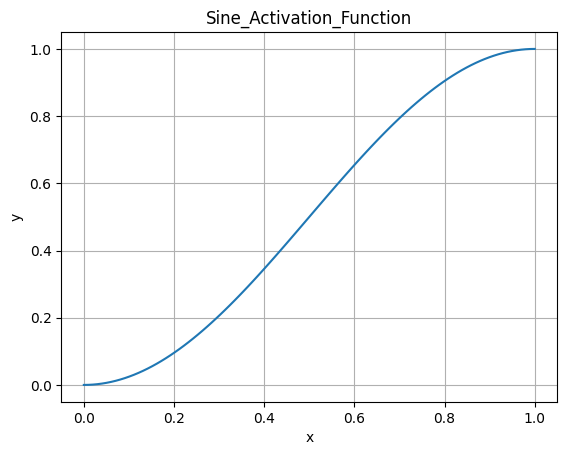

In [10]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 1.0458, -0.0706,  0.0113],
        [ 0.0130,  1.0204,  0.0369],
        [ 0.0398, -0.0305,  1.0451]], device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([ 0.0459, -0.0256,  0.0965], device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 9.9640e-01, -1.6603e-04,  7.4249e-02],
        [ 3.6164e-02,  9.9505e-01,  7.7265e-02],
        [ 1.6386e-02, -3.2348e-02,  1.0427e+00]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([0.0353, 0.0101, 0.0250], device='cuda:0', requires_grad=True)}


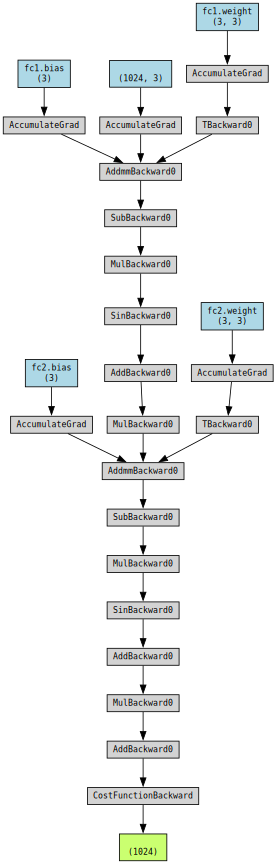

In [11]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [12]:
target, criterion, optimizer = get_ready_to_train(sdl, model,)

Train model and print out results:

In [13]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
    train_model(sdl.iterations,
                model, 
                my_input, 
                target, 
                criterion,
                optimizer,
                print_results=True,
                print_frequency=PRINT_FREQUENCY
                )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 21.012 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 198.81
Epoch 0, fc2.weight grad: 20.82
Epoch 0, fc2.bias grad: 887.96
Epoch 10, Average cost: 21.789 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 10, fc1.weight grad: 0.00
Epoch 10, fc1.bias grad: 46018.11
Epoch 10, fc2.weight grad: 3317.68
Epoch 10, fc2.bias grad: 4256.23
Epoch 20, Average cost: 21.121 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 20, fc1.weight grad: 0.00
Epoch 20, fc1.bias grad: 69374.84
Epoch 20, fc2.weight grad: 1980.70
Epoch 20, fc2.bias grad: 1509.49
Epoch 30, Average cost: 22.379 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 30, fc1.weight grad: 0.00
Epoch 30, fc1.bias grad: 173925.39
Epoch 30, fc2.weight grad: 5212.24
Epoch 30, fc2.bias grad: 4895.27
Epoch 40, Average cost: 22.930 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 40, fc1.weight grad: 0.00
Epoch 40, fc1.bias grad: 264851

In [14]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 21.000 at epoch 0.
The best known cost is 21.000
the hot start cost was 21.000.


Plot loss ratio by epoch:

Graph for Run ID: 20251013-19-24-05-19-24-05 being saved to graphs\20251013-19-24-05\19-24-05.png


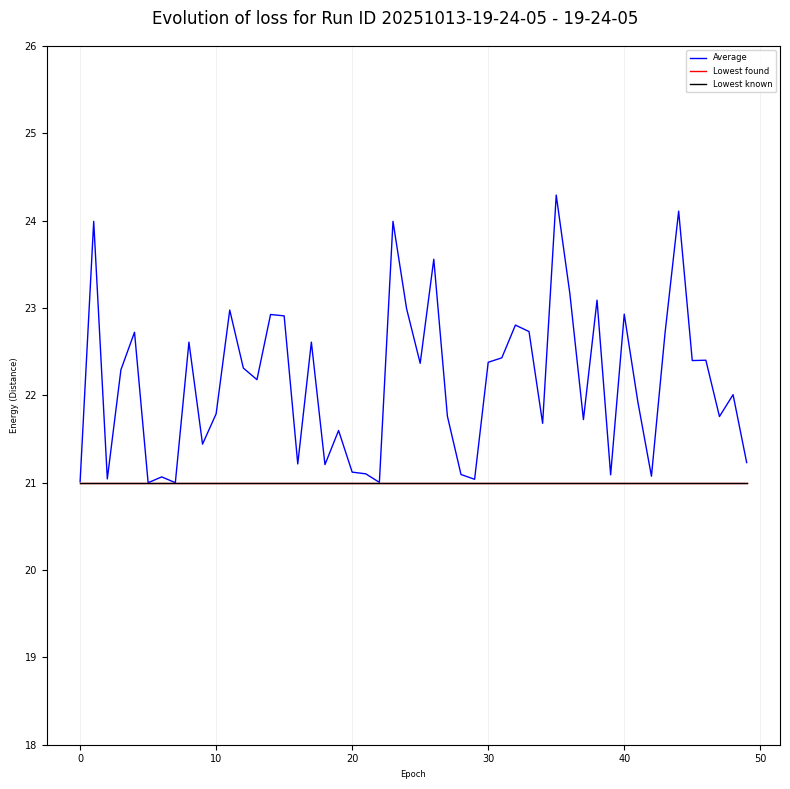

In [15]:
sdl.save_plot()

Print out parameters:

In [16]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 1.0455, -0.0705,  0.0113],
        [ 0.0130,  1.0202,  0.0369],
        [ 0.0398, -0.0305,  1.0448]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([-5818.0674,  6566.4580, -2373.6023], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 57.3914,  34.6171,  51.0542],
        [ 14.5508,  14.1782, 115.5298],
        [  3.2069, -79.1315,  34.4202]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([ 102.9930,   44.3852, -137.8713], device='cuda:0', requires_grad=True)
